# Table of Content

1. [Trained model loading](#load_model)

2. [Create numpy arrays from test images](#numpy_creates)

3. [Calculate prediction](#prediction)

4. [Visualize prediction and ground trust](#prediction_visualize)

5. [Visualize filters in the first 2 convolution layer](#filter_vis)

6. [Visualize max activation in different convolution layers](#visactive)

7. [Evaluate model](#evaluate)
    1. [Confusion matrix](#confusion_matrix)
    2. [Precision&Recall](#prrec)
    3. [ROC curve](#roc)
    4. [Precision-Recall curve](#prcurve)
    5. [Calculate KAPPA score](#kappa)
    6. [Best threshold selecting](#bestthreshold)
    7. [Compare diffretent params](#compareparam)


# Imports

In [231]:
from keras.models import load_model, Model
import utils
import numpy as np
import matplotlib.pyplot as plt
from vis.visualization import visualize_cam
import random
from scipy import interpolate
from tqdm import tqdm_notebook
from sklearn.metrics import cohen_kappa_score
import pandas as pd
plt.style.use('ggplot')

# Trained model loading
<a id = "load_model"></a>

In [2]:
model = load_model('./Models/best_model.h5')
print(model.summary())

C:\Users\YG_Kravchenko\Anaconda3\lib\site-packages\keras\engine\topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 258, 258, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 64) 1792        zero_padding2d_14[0][0]          
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 258, 258, 64) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 

merge_7 (Merge)                 (None, 32, 32, 1024) 0           conv2d_40[0][0]                  
                                                                 conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 32, 32, 512)  4719104     merge_7[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 512)  2359808     conv2d_48[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_8 (UpSampling2D)  (None, 64, 64, 512)  0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 64, 64, 256)  524544      up_sampling2d_8[0][0]            
__________

# Create numpy arrays from test images
<a id = "numpy_creates"></a>

In [3]:
X_path, Y_path = './test_set/images/', './test_set/masks/'
X_test, Y_test = utils.get_training_set(X_path, Y_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:01<00:00, 50.66it/s]


# Calculate prediction
<a id = 'prediction'></a>

In [4]:
prediction = model.predict(X_test, verbose = 1)

77/77 [==============================] - ETA: 1: - ETA: 19s - 116s 2s/step


# Visualize prediction and ground trust
<a id = "prediction_visualize"></a>

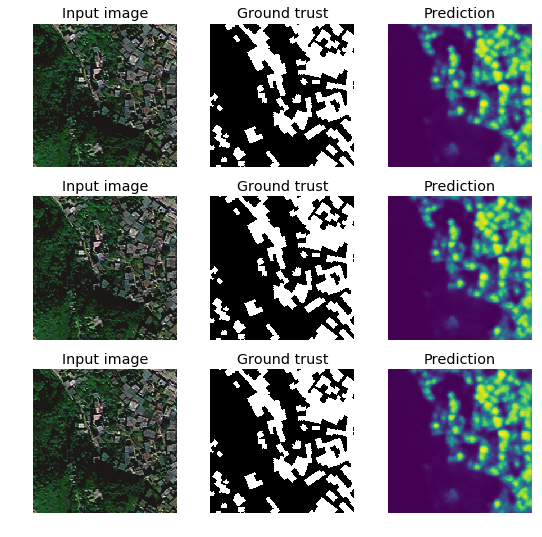

In [5]:
num_images = 3

random_indexes = [np.random.choice(list(range(len(X_test)))) for _ in range(num_images)]
X_test_choiced = X_test[random_indexes]
Y_test_choiced = Y_test[random_indexes]
prediction_choiced = prediction[random_indexes]

fig, ax = plt.subplots(num_images, 3, figsize = (9, num_images*3))

for count, _ in enumerate(X_test_choiced):
    ax[count][0].imshow(X_test_choiced[count])
    ax[count][1].imshow(Y_test_choiced[count][:, :, 0], 'binary_r')
    ax[count][2].imshow(prediction_choiced[count][:, :, 0])
    
    ax[count][0].set_title('Input image')
    ax[count][1].set_title('Ground trust')
    ax[count][2].set_title('Prediction')
    
    for i in range(3):
        ax[count][i].set_axis_off()
        
plt.show()

# Visualize filters in the first 2 convolution layer
<a id = "filter_vis"></a>

In [6]:
# Create filters model
filter_model = Model(inputs=model.layers[0].input, outputs = model.layers[4].output)
print(filter_model.summary())

image = X_test[0]
filters = filter_model.predict(np.expand_dims(image, axis = 0))[0]

fig, ax = plt.subplots(13, 5, figsize = (15, 39))
axes = [ax[i][j] for i in range(13) for j in range(5)]

for i in range(65):
    if i==0:
        axes[i].imshow(image)
        axes[i].set_title('Input image')
    else:
        axes[i].imshow(filters[:, :, i-1], 'magma')
        axes[i].set_title(f"Filter {i-1}")
    axes[i].set_axis_off()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 258, 258, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 256, 256, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________
None


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Visualize max activation in different convolution layers
<a id = "visactive"></a>

A Jupyter Widget

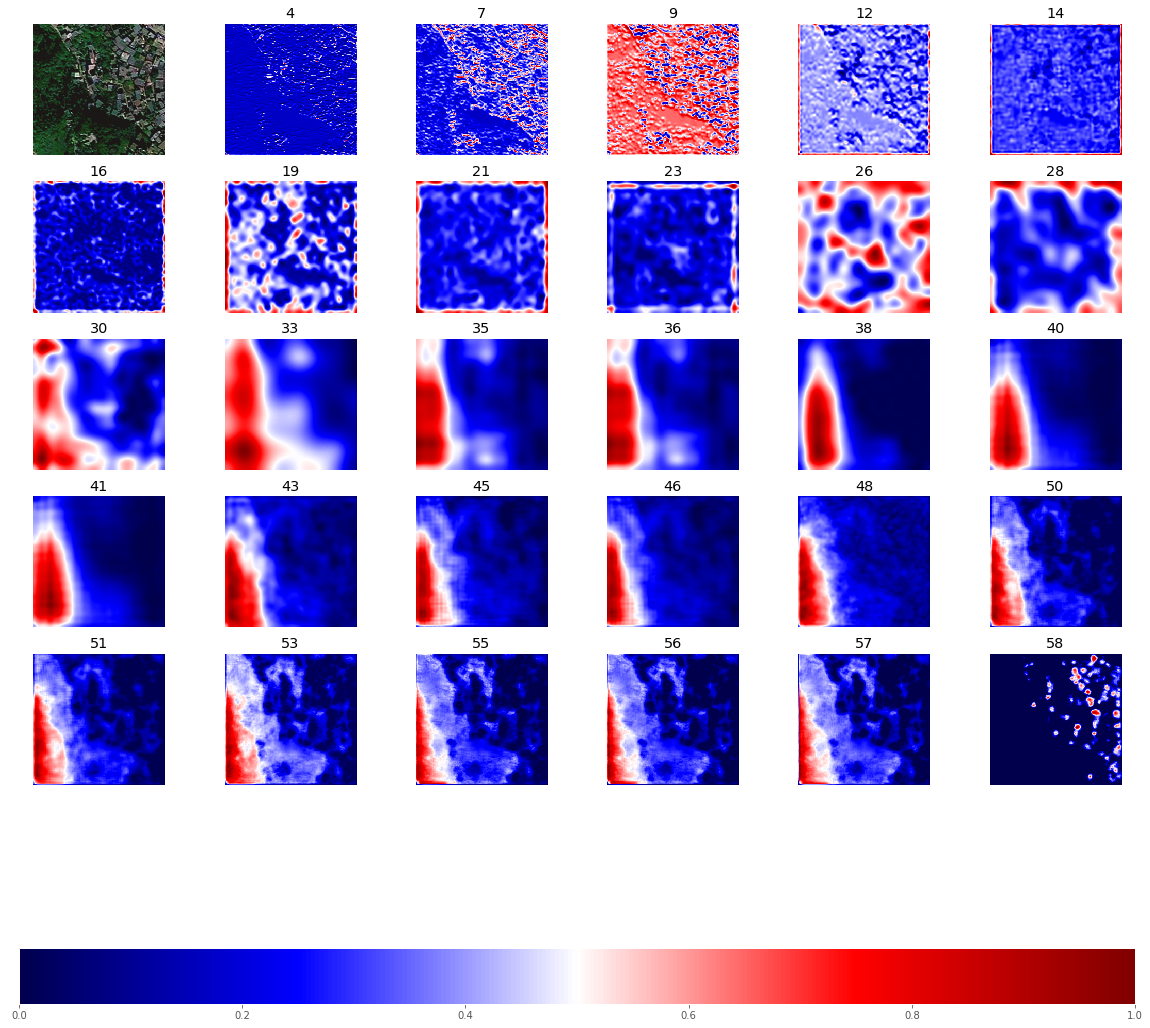

In [168]:
def get_available_indexes(model):
    return [count for count, layer in enumerate(model.layers) if 'Conv2D' in layer.__class__.__name__]

image = random.choice(X_test)
layer_idx = get_available_indexes(model)[1:]
fig, ax = plt.subplots(5, 6, figsize = (20, 20))
axs = [ax[i, j] for i in range(5) for j in range(6)]

ax[0, 0].imshow(image)
ax[0, 0].set_axis_off()
for count, idx in tqdm_notebook(enumerate(layer_idx)):
    filters = model.layers[idx].output_shape[-1]
    activ = visualize_cam(model, idx, list(range(filters)), seed_input = image)
    cbar = axs[count+1].imshow(activ, 'seismic')
    axs[count+1].set_title(f"{idx}")
    axs[count+1].set_axis_off()
fig.colorbar(cm, orientation='horizontal', ax=ax)
plt.show()

# Evaluate model
<a id = 'evaluate'></a>

### Confusion matrix
<a id = 'confusion_matrix'></a>

In [150]:
def get_TP(y_true, y_pred, threshold = 0.5):
    all_pixels = y_true.shape[0]*y_true.shape[1]
    res = y_true[y_pred>threshold]==1
    return len(res[res==True])/all_pixels

def get_TN(y_true, y_pred, threshold = 0.5):
    all_pixels = y_true.shape[0]*y_true.shape[1]
    res = y_true[y_pred<threshold]==0
    return len(res[res==True])/all_pixels
    
def get_FP(y_true, y_pred, threshold = 0.5):
    all_pixels = y_true.shape[0]*y_true.shape[1]
    res = y_true[y_pred>threshold]==0
    return len(res[res==True])/all_pixels

def get_FN(y_true, y_pred, threshold = 0.5):
    all_pixels = y_true.shape[0]*y_true.shape[1]
    res = y_true[y_pred<threshold]==1
    return len(res[res==True])/all_pixels

def get_param(param_name, Y_true, Y_pred, threshold):
    func = {'TP':get_TP, 'TN':get_TN, 'FP':get_FP, 'FN':get_FN}
    return np.array([func[param_name](Y_true[count, :, :, 0], Y_pred[count, :, :, 0], threshold) for count, _ in enumerate(Y_true)]).mean()

In [151]:
th = 0.1
TP = get_param('TP', Y_test, prediction, th)
TN = get_param('TN', Y_test, prediction, th)
FP = get_param('FP', Y_test, prediction, th)
FN = get_param('FN', Y_test, prediction, th)

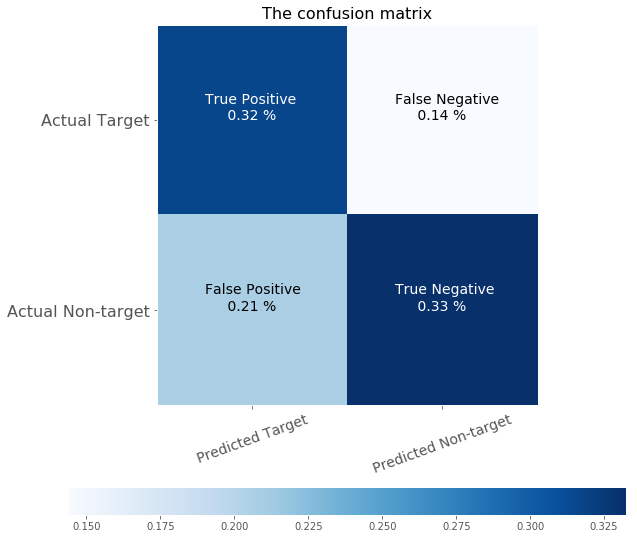

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title('The confusion matrix', fontsize  = 16)
ax.grid(False)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Predicted Target', 'Predicted Non-target'], rotation = 20, fontsize = 14)
ax.set_yticklabels(['Actual Target','Actual Non-target'], fontsize = 16)
cb = ax.imshow(np.array([np.array([TP, FN]), np.array([FP, TN])]), cmap = plt.get_cmap('Blues'))
fig.colorbar(cb, ax=ax, orientation = 'horizontal')
TF = {'TP':{'value_percent': TP,  'coord':(-0.25, 0), 'name':'True Positive'}, 
        'TN':{'value_percent': TN,  'coord':(0.75, 1), 'name':'True Negative'},
        'FP':{'value_percent': FP,  'coord':(-0.25, 1), 'name':'False Positive'},
        'FN':{'value_percent': FN, 'coord':(0.75, 0), 'name':'False Negative'}}

for param in TF:
    if TF[param]['value_percent']>0.29:
        color = 'white'
    else:
        color = 'black'

    ax.annotate("{}\n     {} %".format(TF[param]['name'], round(TF[param]['value_percent'], 2)),xy=(TF[param]['coord']), color=color, fontsize = 14)
plt.show()

### Precision&Recall
<a id = 'prrec'></a>

In [144]:
#define functions for each images

def get_precision(y_true, y_predicted, threshold = 0.5):
    TP = get_TP(y_true, y_predicted, threshold)
    FP = get_FP(y_true, y_predicted, threshold)
    return TP/(TP+FP)
    
def get_recall(y_true, y_predicted):
    TP = get_TP(y_true, y_predicted, threshold)
    FN = get_FN(y_true, y_predicted, threshold)
    return TP/(TP+FN)


#calculate param for all images
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print(f"Precision: {precision}\nRecall: {recall}")

Precision: 0.6037126464621999
Recall: 0.6872236106162819


### ROC curve
<a id = 'roc'></a>

In [214]:
def get_fpr(Y_true, Y_pred, threshold = 0.5):
    FP = get_param('FP', Y_true, Y_pred, threshold)
    TN = get_param('TN', Y_true, Y_pred, threshold)
    return FP/(FP+TN)

def get_tpr(Y_true, Y_pred, threshold = 0.5):
    TP = get_param('TP', Y_true, Y_pred, threshold)
    FN = get_param('FN', Y_true, Y_pred, threshold)
    return TP/(TP+FN)

thresholds = np.linspace(0, 1, 20)

TPR = [get_tpr(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]
FPR = [get_fpr(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]  
f = interpolate.interp1d(FPR, TPR)
FPR = np.linspace(0, 1, 100)
TPR= [f(i) for i in FPR]

A Jupyter Widget

A Jupyter Widget

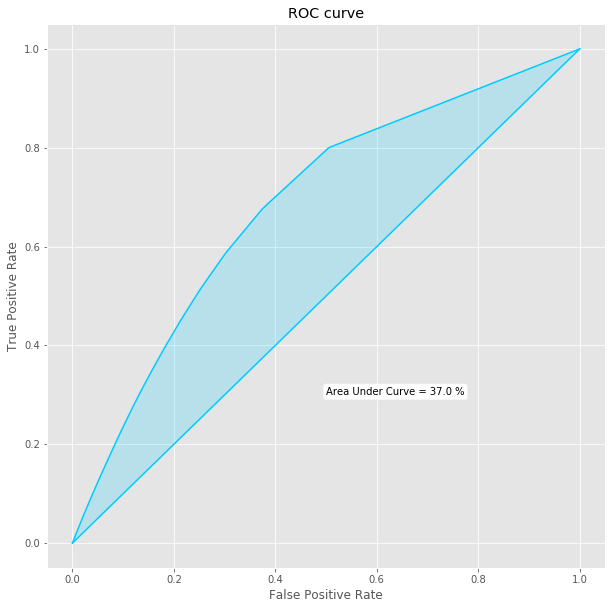

In [219]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(FPR, TPR, '-', color = (0, 0.8, 1))
ax.plot([0, 1], [0, 1], '-', color = (0, 0.8, 1))
ax.fill(FPR, TPR,color = (0, 0.8, 1), alpha = 0.2)
area_under_curve = (sum(TPR)-50)*2
ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.annotate('Area Under Curve = {} %'.format(round(area_under_curve)), xy = (0.5, 0.3), bbox=dict(boxstyle="round", fc="w"))
plt.show()

### Precision-Recall curve
<a id = 'prcurve'></a>

In [220]:
def get_positive_recall_all(Y_true, Y_pred, threshold):
    TP = get_param('TP', Y_true, Y_pred, threshold)
    FN = get_param('FN', Y_true, Y_pred, threshold)
    return TP/(TP+FN)

def get_negative_recall_all(Y_true, Y_pred, threshold):
    TN = get_param('TN', Y_true, Y_pred, threshold)
    FP = get_param('FP', Y_true, Y_pred, threshold)
    return TN/(TN+FP)

def get_positive_precision_all(Y_true, Y_pred, threshold):
    TP = get_param('TP', Y_true, Y_pred, threshold)
    FP = get_param('FP', Y_true, Y_pred, threshold)
    return TP/(TP+FP)

def get_negative_precision_all(Y_true, Y_pred, threshold):
    TN = get_param('TN', Y_true, Y_pred, threshold)
    FN = get_param('FN', Y_true, Y_pred, threshold)
    return TN/(TN+FN)

thresholds = np.linspace(0, 1, 20)

PR = [get_positive_recall_all(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]
NR = [get_negative_recall_all(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]
PP = [get_positive_precision_all(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]
NP = [get_negative_precision_all(Y_test, prediction, threshold) for threshold in tqdm_notebook(thresholds)]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

C:\Users\YG_Kravchenko\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


A Jupyter Widget

C:\Users\YG_Kravchenko\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


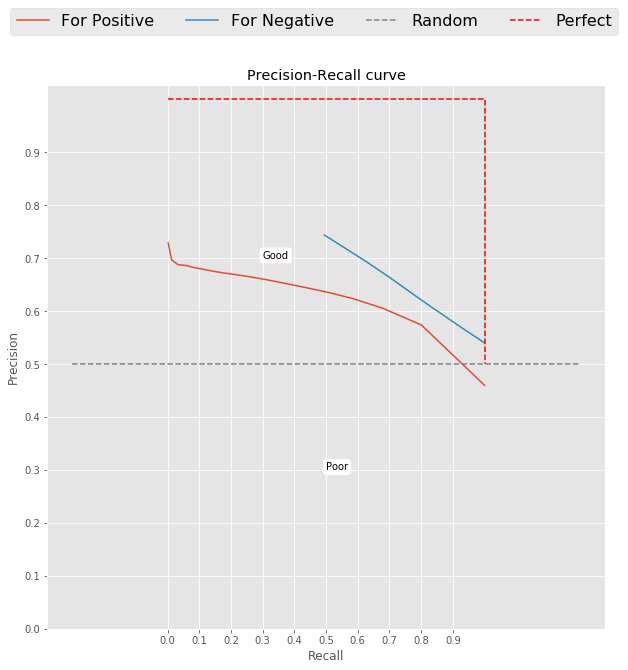

In [227]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(PR, PP, '-', label = 'For Positive')
ax.plot(NR, NP, '-', label = 'For Negative')
ax.plot([-0.3,1.3], [0.5, 0.5], '--', label = 'Random', color = 'grey')
ax.plot([0,1,1], [1,1,0.5], 'r--', label = 'Perfect')


ax.annotate('Good', xy = (0.3, 0.7), bbox=dict(boxstyle="round", fc="w"))
ax.annotate('Poor', xy = (0.5, 0.3), bbox=dict(boxstyle="round", fc="w"))

ax.set_title('Precision-Recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xticks(np.arange(0,1,0.1))
ax.set_yticks(np.arange(0,1,0.1))
fig.legend(loc = 'upper center' , fontsize = 16,  ncol = 4)
plt.show()

### Calculate KAPPA score
<a id = 'kappa'></a>

In [236]:
th = 0.2

def get_kappa(Y_true, Y_pred, threshold):  
    print(f'Calculate kappa for {threshold} threshold')
    return np.array([cohen_kappa_score((Y_true[count, :, :, 0]).flatten(),
                                       np.array(Y_pred[count, :, :, 0]>threshold).astype('byte').flatten())
                     for count, _ in tqdm_notebook(enumerate(Y_true))]).mean()

print(f'KAPPA({th}) = {get_kappa(Y_test, prediction, th)}')

Calculate kappa for 0.2 threshold


A Jupyter Widget

KAPPA(0.2) = 0.2031174387892878


### Best threshold selecting

<a id = bestthreshold></a>

In [237]:
#Get kappa for different threshold
kappas = [get_kappa(Y_test, prediction, th) for th in thresholds]

Calculate kappa for 0.0 threshold


A Jupyter Widget

Calculate kappa for 0.05263157894736842 threshold


A Jupyter Widget

Calculate kappa for 0.10526315789473684 threshold


A Jupyter Widget

Calculate kappa for 0.15789473684210525 threshold


A Jupyter Widget

Calculate kappa for 0.21052631578947367 threshold


A Jupyter Widget

Calculate kappa for 0.2631578947368421 threshold


A Jupyter Widget

Calculate kappa for 0.3157894736842105 threshold


A Jupyter Widget

Calculate kappa for 0.3684210526315789 threshold


A Jupyter Widget

Calculate kappa for 0.42105263157894735 threshold


A Jupyter Widget

Calculate kappa for 0.47368421052631576 threshold


A Jupyter Widget

Calculate kappa for 0.5263157894736842 threshold


A Jupyter Widget

Calculate kappa for 0.5789473684210527 threshold


A Jupyter Widget

Calculate kappa for 0.631578947368421 threshold


A Jupyter Widget

Calculate kappa for 0.6842105263157894 threshold


A Jupyter Widget

Calculate kappa for 0.7368421052631579 threshold


A Jupyter Widget

Calculate kappa for 0.7894736842105263 threshold


A Jupyter Widget

Calculate kappa for 0.8421052631578947 threshold


A Jupyter Widget

Calculate kappa for 0.894736842105263 threshold


A Jupyter Widget

Calculate kappa for 0.9473684210526315 threshold


A Jupyter Widget

Calculate kappa for 1.0 threshold


A Jupyter Widget

The best kappa metrics (0.2200607412014639) in 0.10526315789473684 threshold


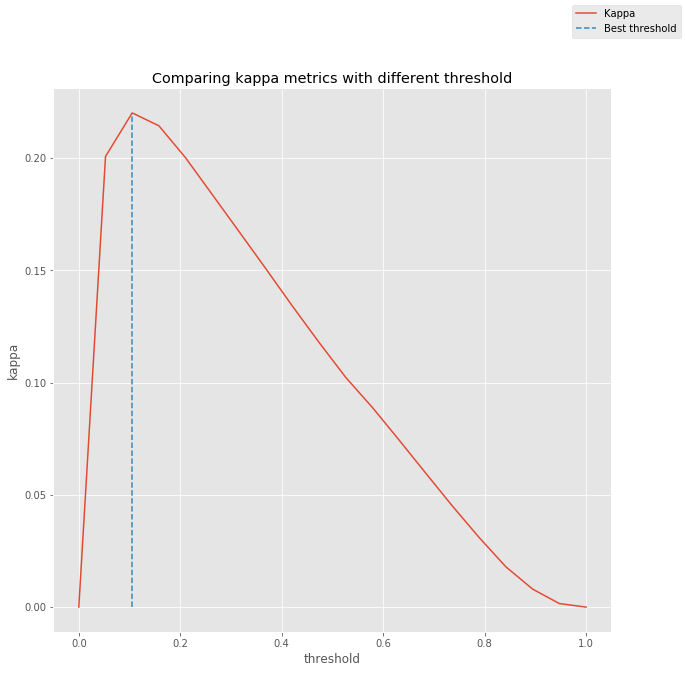

In [243]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(thresholds, kappas, label = 'Kappa')

best_kappa_th = thresholds[kappas.index(max(kappas))]
print(f"The best kappa metrics ({max(kappas)}) in {best_kappa_th} threshold")

ax.plot([best_kappa_th, best_kappa_th], [0, max(kappas)], '--', label = 'Best threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('kappa')
ax.set_title('Comparing kappa metrics with different threshold')
fig.legend()
plt.show()

In [248]:
#Get pure accuracy for different threshold
def get_accuracy(Y_true, Y_pred, threshold):
    TP = get_param('TP', Y_true, Y_pred, threshold)
    TN = get_param('TN', Y_true, Y_pred, threshold)
    return (TP+TN)

acc = [get_accuracy(Y_test, prediction, th) for th in thresholds]

The best accuracy  (0.6489473813539975) in 0.10526315789473684 threshold


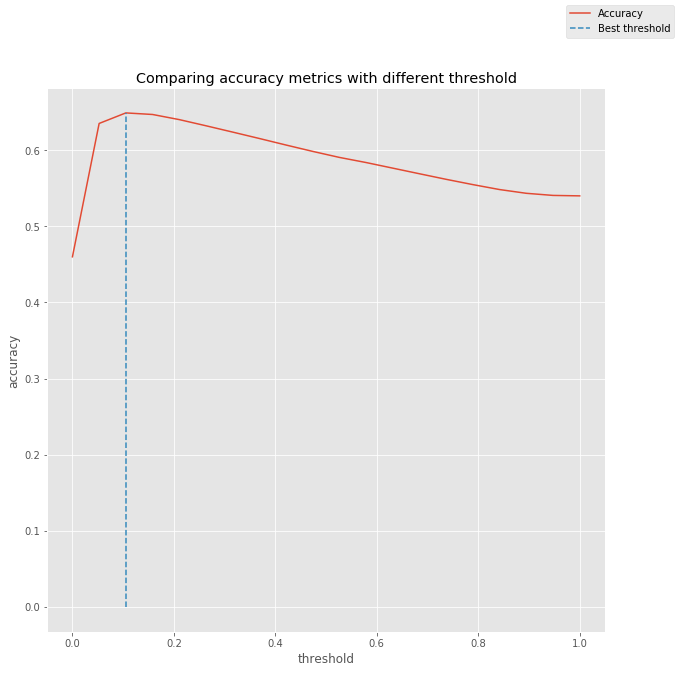

In [249]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(thresholds, acc, label = 'Accuracy')

best_acc_th = thresholds[acc.index(max(acc))]
print(f"The best accuracy  ({max(acc)}) in {best_acc_th} threshold")

ax.plot([best_acc_th, best_acc_th], [0, max(acc)], '--', label = 'Best threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('accuracy')
ax.set_title('Comparing accuracy metrics with different threshold')
fig.legend()
plt.show()

### Compare diffretent params
<a id = compareparam></a>

In [ ]:
#Let's put together all metrics that was calculated above
metrics = pd.Series({'Accuracy': max(acc),
          'Best threshold': round(best_acc_th, 3),
          'TP': get_param('TP', Y_test, prediction, best_acc_th),
          'TN': get_param('TN', Y_test, prediction, best_acc_th),
          'FP': get_param('FP', Y_test, prediction, best_acc_th),
          'FN': get_param('FN', Y_test, prediction, best_acc_th),
          'Positive Precision': get_positive_precision_all(Y_test, prediction, best_acc_th),
          'Negative Precision': get_negative_precision_all(Y_test, prediction, best_acc_th),
          'Positive Recall': get_positive_recall_all(Y_test, prediction, best_acc_th),
          'Negative Recall': get_negative_recall_all(Y_test, prediction, best_acc_th),
          'True Positive Rate': get_tpr(Y_test, prediction, best_acc_th),
           'False Positive Rate': get_fpr(Y_test, prediction, best_acc_th),
           'Kappa':max(kappas)
          })

In [252]:
print(metrics)

Accuracy               0.648947
Best threshold         0.105000
FN                     0.148603
FP                     0.202450
False Positive Rate    0.374899
Kappa                  0.220061
Negative Precision     0.694336
Negative Recall        0.625101
Positive Precision     0.606003
Positive Recall        0.676942
TN                     0.337562
TP                     0.311386
True Positive Rate     0.676942
dtype: float64
